In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import gensim
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import numpy as np
import re
import nltk
import time
import seaborn as sns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
%matplotlib inline

In [2]:
reviews = pd.read_csv("corpus.csv", encoding='latin-1')

In [3]:
reviews.dtypes

text     object
label    object
dtype: object

In [4]:
reviews.label.value_counts() / reviews.label.shape

__label__1     0.5097
__label__2     0.4903
Name: label, dtype: float64

In [5]:
lb_make = LabelEncoder()
reviews["label"] = lb_make.fit_transform(reviews["label"])

In [6]:
reviews["length"] = [len(i) for i in reviews.text]

In [7]:
reviews.head()

,text,label,length
0,Stuning even for the non-gamer: This sound tr...,1,428
1,The best soundtrack ever to anything.: I'm re...,1,510
2,Amazing!: This soundtrack is my favorite musi...,1,761
3,Excellent Soundtrack: I truly like this sound...,1,744
4,"Remember, Pull Your Jaw Off The Floor After H...",1,482


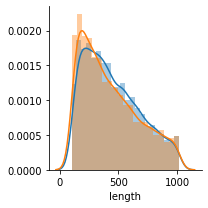

In [8]:
g = sns.FacetGrid(reviews, hue="label")
g = g.map(sns.distplot, "length")

In [9]:
def print_seperator():
    print("============================================================================================")

def pretty_print(table):
    print(pd.DataFrame(table, columns=['Model', 'Acc', 'Runtime', 'AUC']))

In [10]:
def run_model(model, name=None):
    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:,1])
    auc = metrics.auc(fpr, tpr)
    model_table.append({'Model':name, 'Acc': accuracy, 'Runtime': total_time, 'AUC':auc})
    print('Model: {}', name)
    print('Accuracy: {}', accuracy)
    print('Time: {}', total_time)
    print('AUC: {}', auc)
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred))
    plt.plot(fpr, tpr, label='AUC')
    plt.plot([0, 1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    print_seperator()

In [11]:
model_table = []
seed = 3

In [12]:
def clean_text(text):
    text = text.strip().lower()
    text = text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/^]', ' ', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    

    return text

In [13]:
count_vect = CountVectorizer(stop_words="english",
                             preprocessor=clean_text)

x_counts = count_vect.fit_transform(reviews.text)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_counts, reviews.label, test_size=0.3, random_state=seed)

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: {} BOW - LR
Accuracy: {} 0.8316666666666667
Time: {} 0.603874683380127
AUC: {} 0.906544694285901
[[1251  272]
 [ 233 1244]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1523
           1       0.82      0.84      0.83      1477

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



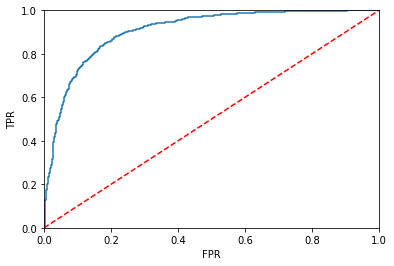

Model: {} BOW - XGB
Accuracy: {} 0.7673333333333333
Time: {} 17.66939091682434
AUC: {} 0.8602093558885623
[[1217  306]
 [ 392 1085]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1523
           1       0.78      0.73      0.76      1477

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



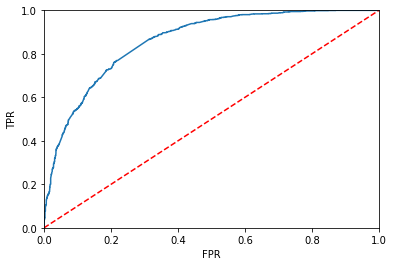

In [15]:
run_model(LogisticRegression(), "BOW - LR")
run_model(XGBClassifier(), "BOW - XGB")

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: {} LR tfidf
Accuracy: {} 0.8556666666666667
Time: {} 0.15908598899841309
AUC: {} 0.9305066766726361
[[1308  218]
 [ 215 1259]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1526
           1       0.85      0.85      0.85      1474

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



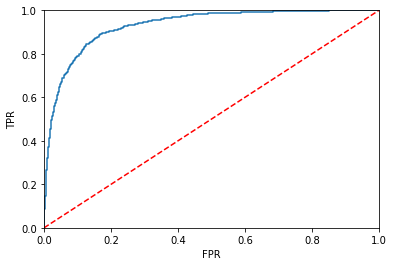

Model: {} xgb tfidf
Accuracy: {} 0.7816666666666666
Time: {} 17.99554204940796
AUC: {} 0.8638179737556706
[[1239  287]
 [ 368 1106]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1526
           1       0.79      0.75      0.77      1474

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



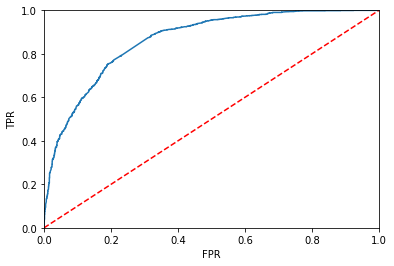

In [16]:
tfidf_vector = TfidfVectorizer(stop_words="english",
                               preprocessor=clean_text)
x_train_tfidf = tfidf_vector.fit_transform(reviews.text)
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, reviews.label, test_size=0.3)
run_model(LogisticRegression(), "LR tfidf")
run_model(XGBClassifier(), "xgb tfidf")

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: {} LR tfidf ngram2
Accuracy: {} 0.851
Time: {} 0.2888932228088379
AUC: {} 0.9271574835906445
[[1296  212]
 [ 235 1257]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1508
           1       0.86      0.84      0.85      1492

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



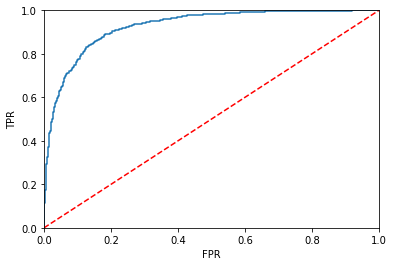

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: {} LR tfidf ngram3
Accuracy: {} 0.839
Time: {} 0.6769821643829346
AUC: {} 0.9202993914937341
[[1329  233]
 [ 250 1188]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1562
           1       0.84      0.83      0.83      1438

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



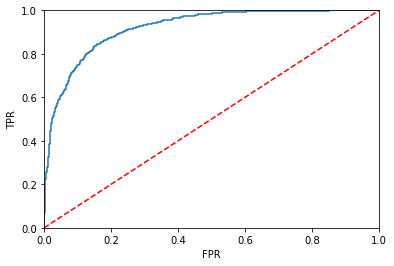

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: {} LR tfidf ngram4
Accuracy: {} 0.8343333333333334
Time: {} 0.5787689685821533
AUC: {} 0.919078297985861
[[1287  243]
 [ 254 1216]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1530
           1       0.83      0.83      0.83      1470

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



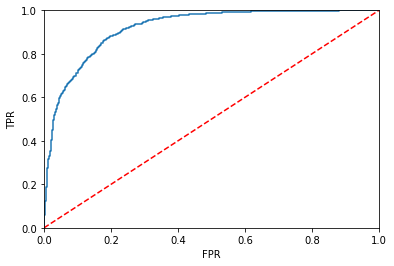

In [17]:
for i in range(2, 5):
    
    tfidf_vector = TfidfVectorizer(stop_words="english",
                                   preprocessor=clean_text,
                                   ngram_range=(1, i))
    x_train_tfidf_ngrams = tfidf_vector.fit_transform(reviews.text)
    x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf_ngrams, reviews.label, test_size=0.3)
    run_model(LogisticRegression(), "LR tfidf ngram" + str(i))
    #run_model(XGBClassifier(), "xgb tfidf ngram" + str(i), model_table)

In [18]:
pretty_print(model_table)

             Model       Acc    Runtime       AUC
0         BOW - LR  0.831667   0.603875  0.906545
1        BOW - XGB  0.767333  17.669391  0.860209
2         LR tfidf  0.855667   0.159086  0.930507
3        xgb tfidf  0.781667  17.995542  0.863818
4  LR tfidf ngram2  0.851000   0.288893  0.927157
5  LR tfidf ngram3  0.839000   0.676982  0.920299
6  LR tfidf ngram4  0.834333   0.578769  0.919078


In [19]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [20]:
def clean_text_porter(text):
    text = text.strip().lower()
    text = text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/^]', ' ', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = " ".join([ps.stem(word) for word in text.split(" ")])
    return text

In [21]:
def clean_text_lemmatize(text):
    text = text.strip().lower()
    text = text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/^]', ' ', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])
    return text

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_w

Model: {} LR tfidf porter
Accuracy: {} 0.852
Time: {} 0.11126375198364258
AUC: {} 0.9326296755670449
[[1311  226]
 [ 218 1245]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1537
           1       0.85      0.85      0.85      1463

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



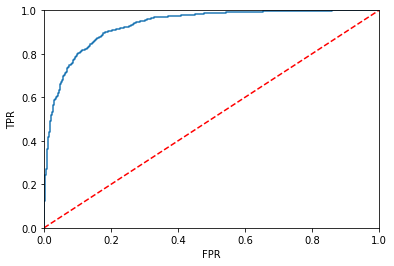

In [22]:
tfidf_vector = TfidfVectorizer(stop_words="english",
                               preprocessor=clean_text_porter)
x_train_tfidf = tfidf_vector.fit_transform(reviews.text)
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, reviews.label, test_size=0.3)
run_model(LogisticRegression(), "LR tfidf porter")
#run_model(XGBClassifier(), "xgb tfidf porter")

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: {} LR tfidf lem
Accuracy: {} 0.8506666666666667
Time: {} 0.08347058296203613
AUC: {} 0.9266309145431155
[[1323  214]
 [ 234 1229]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1537
           1       0.85      0.84      0.85      1463

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



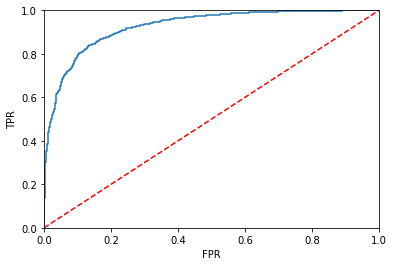

In [23]:
tfidf_vector = TfidfVectorizer(stop_words="english",
                               preprocessor=clean_text_lemmatize)
x_train_tfidf = tfidf_vector.fit_transform(reviews.text)
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, reviews.label, test_size=0.3)
run_model(LogisticRegression(), "LR tfidf lem")
#run_model(XGBClassifier(), "xgb tfidf lem")

In [24]:
pretty_print(model_table)

             Model       Acc    Runtime       AUC
0         BOW - LR  0.831667   0.603875  0.906545
1        BOW - XGB  0.767333  17.669391  0.860209
2         LR tfidf  0.855667   0.159086  0.930507
3        xgb tfidf  0.781667  17.995542  0.863818
4  LR tfidf ngram2  0.851000   0.288893  0.927157
5  LR tfidf ngram3  0.839000   0.676982  0.920299
6  LR tfidf ngram4  0.834333   0.578769  0.919078
7  LR tfidf porter  0.852000   0.111264  0.932630
8     LR tfidf lem  0.850667   0.083471  0.926631


In [25]:
w2v = gensim.models.KeyedVectors.load_word2vec_format("models/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [36]:
w2v.init_sims(replace=True)

In [39]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens  
x_train, x_test, y_train, y_test = train_test_split(reviews.text, reviews.label, test_size=0.3)

test_tokenized = [w2v_tokenize_text(text) for text in x_test]
train_tokenized = [w2v_tokenize_text(text) for text in x_train]

x_train = word_averaging_list(w2v,train_tokenized)
x_test = word_averaging_list(w2v,test_tokenized)

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


In [ ]:
run_model(LogisticRegression(), "LR w2v")
run_model(XGBClassifier(), "xgb w2v")

In [ ]:
pretty_print(model_table)